# Project - Sales Forecasting Accuracy Increasing 

In [1]:
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from scipy.optimize import minimize
from pandas.plotting import autocorrelation_plot

import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('For USML.csv', sep=";")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 13 columns):
Period        81 non-null int64
Forecast 1    81 non-null int64
Actual 1      81 non-null int64
Forecast 2    81 non-null int64
Actual 2      81 non-null int64
Forecast 3    81 non-null int64
Actual 3      81 non-null int64
Forecast 4    81 non-null int64
Actual 4      81 non-null int64
Forecast 5    81 non-null int64
Actual 5      81 non-null int64
Forecast 6    81 non-null int64
Actual 6      81 non-null int64
dtypes: int64(13)
memory usage: 8.3 KB


In [3]:
data.describe()

,Period,Forecast 1,Actual 1,Forecast 2,Actual 2,Forecast 3,Actual 3,Forecast 4,Actual 4,Forecast 5,Actual 5,Forecast 6,Actual 6
count,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000
mean,41.000000,9056.345679,8701.000000,878.074074,992.444444,3416.753086,3237.037037,891.358025,881.888889,48.876543,165.148148,57.925926,105.925926
std,23.526581,2793.121874,2573.329633,463.331193,705.503774,1032.982424,1084.246391,380.930220,645.320754,70.220792,360.988300,80.966162,160.372830
min,1.000000,2940.000000,3885.000000,269.000000,72.000000,1500.000000,858.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,21.000000,6830.000000,6867.000000,525.000000,537.000000,2640.000000,2382.000000,600.000000,408.000000,0.000000,42.000000,0.000000,12.000000
50%,41.000000,9150.000000,8109.000000,840.000000,834.000000,3300.000000,3345.000000,870.000000,738.000000,0.000000,90.000000,0.000000,51.000000
75%,61.000000,10620.000000,10611.000000,1050.000000,1311.000000,4050.000000,3762.000000,1095.000000,1182.000000,90.000000,156.000000,120.000000,120.000000
max,81.000000,15150.000000,15396.000000,3099.000000,3966.000000,5850.000000,7365.000000,1827.000000,3270.000000,426.000000,3180.000000,291.000000,879.000000


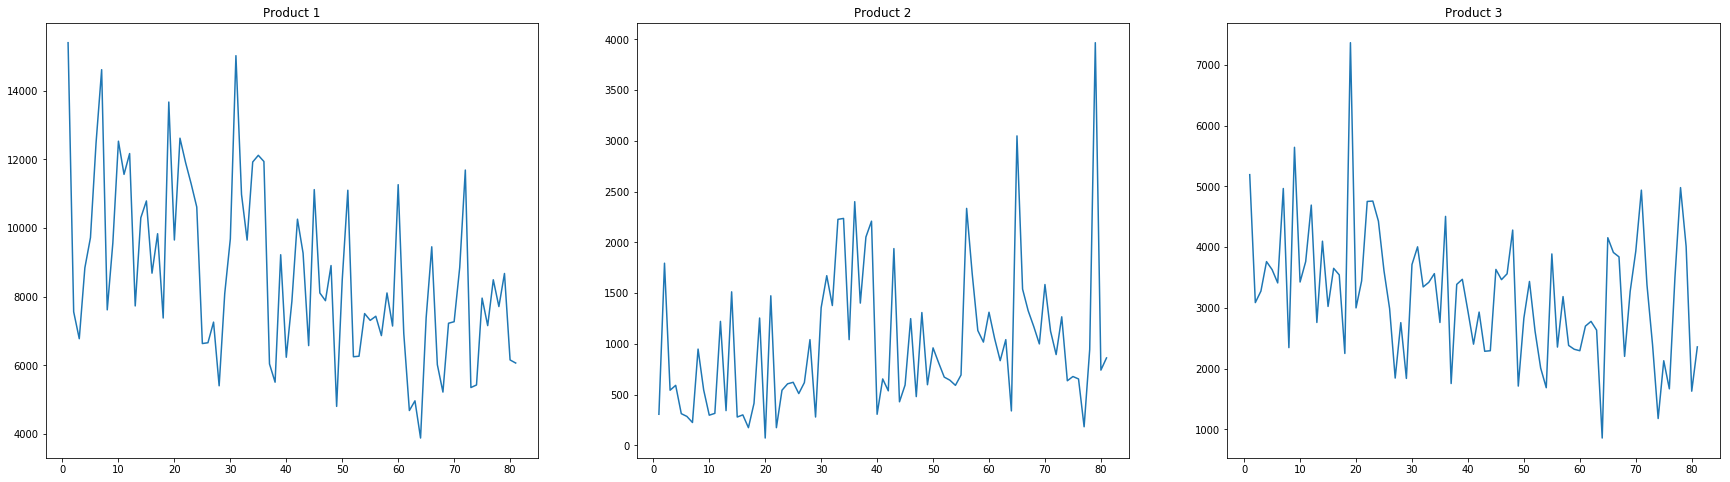

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 8));
axes[0].plot(data["Period"],data["Actual 1"]);
axes[0].set_title("Product 1");
axes[1].plot(data["Period"],data["Actual 2"]);
axes[1].set_title("Product 2");
axes[2].plot(data["Period"],data["Actual 3"]);
axes[2].set_title("Product 3");

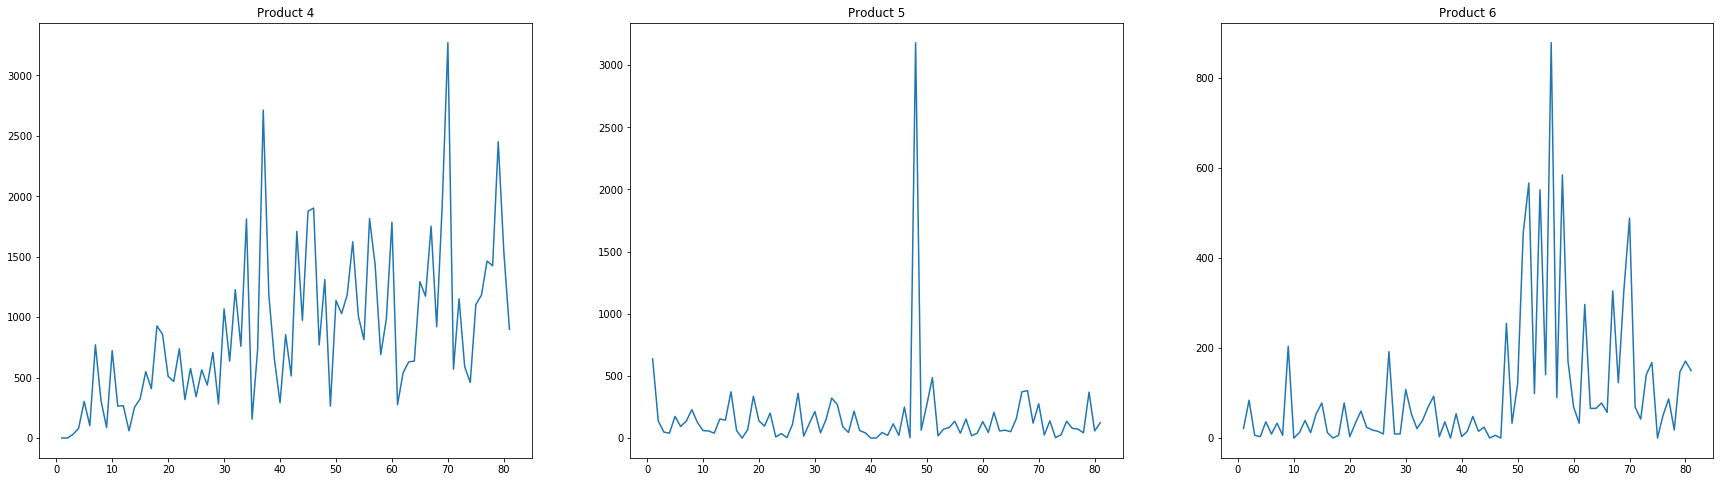

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 8));
axes[0].plot(data["Period"],data["Actual 4"]);
axes[0].set_title("Product 4");
axes[1].plot(data["Period"],data["Actual 5"]);
axes[1].set_title("Product 5");
axes[2].plot(data["Period"],data["Actual 6"]);
axes[2].set_title("Product 6");

# ARIMA Product #2

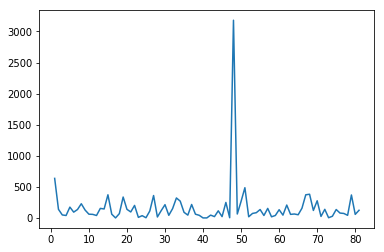

In [6]:
#We can see that Sales dataset has a clear trend. This suggests that the time series is not stationary and 
#will require differencing to make it stationary, at least a difference order of 1.
plt.plot(data["Period"],data["Actual 5"]);

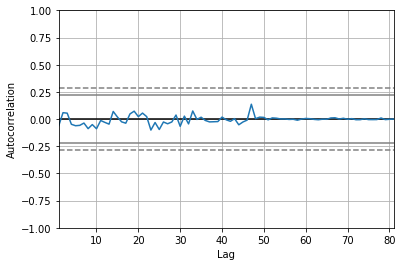

In [7]:
#https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
#Let’s also take a quick look at an autocorrelation plot of the time series. 
#We can see that there is no significant correlation with the lags 
#A good starting point for the AR parameter of the model may be 0.
autocorrelation_plot(data["Actual 5"]);

count      81.000000
mean      165.148148
std       360.988300
min         0.000000
25%        42.000000
50%        90.000000
75%       156.000000
max      3180.000000
Name: Actual 5, dtype: float64

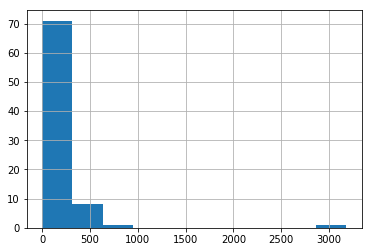

In [8]:
itog1 = data["Actual 5"].describe()
data["Actual 5"].hist()
itog1

Как можно заметить из характеристик и гистограммы, ряд у нас не однородный и имеет относительно 
большой разброс о чем свидетельствует коэффициент вариации: LaTeX:V = \frac {\sigma}{\bar{x}}, где 
        LaTeX:\sigma — cреднеквадратическое отклонение, LaTeX:\bar{x} — среднее арифметическое выборки. В нашем случае он равен:

In [9]:
print("V = %f" % (itog1['std']/itog1['mean']))

V = 2.185845


In [17]:
elements = np.array(data["Actual 5"])

mean = np.mean(elements, axis=0)
sd = np.std(elements, axis=0)

final_list5 = [x for x in data["Actual 5"] if (x > mean - 2 * sd)]
final_list5 = [x for x in final_list5 if (x < mean + 2 * sd)]
df5=pd.DataFrame(final_list5)

In [19]:
df5.tail()

,0
75,72
76,42
77,369
78,57
79,123


Проведем тест Харки — Бера для определения номарльности распределения, чтобы подтвердить предположение об однородности. Для этого в существует функция jarque_bera(), которая возвращает значения данной статистики:

In [20]:
from statsmodels.iolib.table import SimpleTable
row =  [u'JB', u'p-value', u'skew', u'kurtosis']
jb_test = sm.stats.stattools.jarque_bera(data["Actual 5"])
a = np.vstack([jb_test])
itog1 = SimpleTable(a, row)
print (itog1)

        JB         p-value        skew            kurtosis     
---------------------------------------------------------------
12334.027648135718   0.0   7.354839243800842 61.635757600206034
---------------------------------------------------------------


#https://habr.com/post/207160/
#Значение данной статистика свидетельствует о том, нулевая гипотеза о нормальности распределения
#отвергается с большой вероятностью (probably > 0.05), и, следовательно, наш ряд НЕ имеет нормального распределения.

Многие методы и модели основаны на предположениях о стационарности ряда, но как было замечено ранее наш ряд таковым скорее всего не является. Поэтому для проверки проверки стационарности давайте проведем обобщенный тест Дикки-Фуллера на наличие единичных корней. Для этого в модуле statsmodels есть функция adfuller():

In [21]:
test = sm.tsa.adfuller(data["Actual 5"])
print ('adf: ', test[0])
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -9.46624692474495
p-value:  4.222480898079624e-16
Critical values:  {'1%': -3.5148692050781247, '5%': -2.8984085156250003, '10%': -2.58643890625}
единичных корней нет, ряд стационарен


Проведенный тест подтвердил предположения о не стационарности ряда. Во многих случаях взятие разности рядов позволяет это сделать.Если, например, первые разности ряда стационарны, то он называется интегрированным рядом первого порядка.
Итак, давайте определим порядок интегрированного ряда для нашего ряда:

In [22]:
ts1 = data["Actual 5"].diff(periods=1).dropna()

В коде выше функция diff() вычисляет разность исходного ряда с рядом с заданным смещением периода. Период смещения передается как параметр period. Т.к. в разности первое значение получиться неопределенным, то нам надо избавиться от него для этого и используется метод dropna().
Проверим получившийся ряд на стационарность:


In [23]:
test = sm.tsa.adfuller(ts1)
print ('adf: ', test[0])
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -8.187955560903937
p-value:  7.80677478714863e-13
Critical values:  {'1%': -3.518281134660583, '5%': -2.899878185191432, '10%': -2.5872229937594873}
единичных корней нет, ряд стационарен


Как видно из кода выше получившийся ряд первых разностей приблизился к стационарному. Для полной уверенности разобъем его на несколько промежутков и убедимся мат. ожидания на разных интервалах:

In [24]:
m = ts1.index[int(len(ts1.index)/2+1)]
r1 = sm.stats.DescrStatsW(ts1[m:])
r2 = sm.stats.DescrStatsW(ts1[:m])
print ('p-value: ', sm.stats.CompareMeans(r1,r2).ttest_ind()[1])

p-value:  0.8840871194359888


Высокое p-value дает нам возможность утверждать, что нулевая гипотеза о равенстве средних верна, что свидетельствует о стационарности ряда. Осталось убедиться в отсутствии тренда для этого построим график нашего нового ряда:

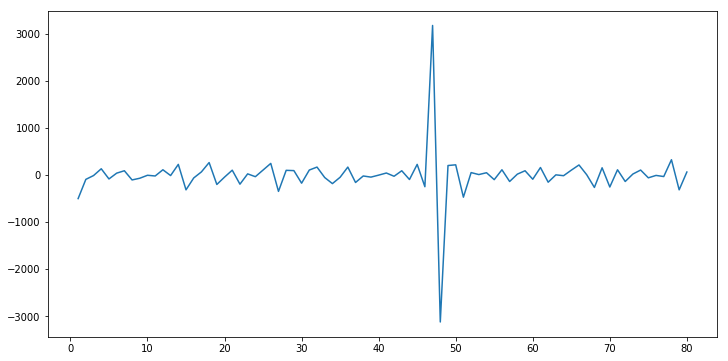

In [25]:
ts1.plot(figsize=(12,6));

Тренд действительно отсутствует, таким образом ряд первых разностей является стационарным, а наш исходный ряд — интегрированным рядом первого порядка.
Для моделирования будем использовать модель ARIMA, построенную для ряда первых разностей.
Итак, чтобы построить модель нам нужно знать ее порядок, состоящий из 2-х параметров:
p — порядок компоненты AR
d — порядок интегрированного ряда
q — порядок компонетны MA

Параметр d есть и он равет 1, осталось определить p и q. Для их определения нам надо изучить авторкорреляционную(ACF) и частично автокорреляционную(PACF) функции для ряда первых разностей.
ACF поможет нам определить q, т. к. по ее коррелограмме можно определить количество автокорреляционных коэффициентов сильно отличных от 0 в модели MA
PACF поможет нам определить p, т. к. по ее коррелограмме можно определить максимальный номер коэффициента сильно отличный от 0 в модели AR.
Чтобы построить соответствующие коррелограммы, в пакете statsmodels имеются следующие функции: plot_acf() и plot_pacf(). Они выводят графики ACF и PACF, у которых по оси X откладываются номера лагов, а по оси Y значения соответствующих функций. Нужно отметить, что количество лагов в функциях и определяет число значимых коэффициентов. Итак, наши функции выглядят так:

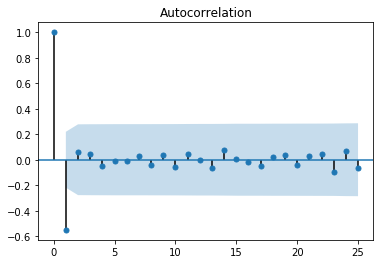

In [26]:
#ig = plt.figure(figsize=(12,8))
#ax1 = fig.add_subplot(211)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts1,lags=25);

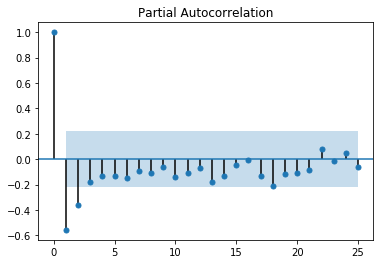

In [27]:
#ax2 = fig.add_subplot(212)
plot_pacf(ts1, lags=25);

После изучения коррелограммы PACF можно сделать вывод, что p = 1, т.к. на ней только 1 лаг сильно отличнен от нуля. По коррелограмме ACF можно увидеть, что q = 1, т.к. после лага 1 значении функций резко падают.
Итак, когда известны все параметры можно построить модель, но для ее построения мы возмем не все данные, а только часть. Данные из части не попавших в модель мы оставим для проверки точности прогноза нашей модели:

In [28]:
ts1_model = data["Actual 5"][:70]
model1 = sm.tsa.ARIMA(ts1_model, order=(0,1,1)).fit(disp=0)

In [29]:
print (model1.summary())

                             ARIMA Model Results                              
Dep. Variable:             D.Actual 5   No. Observations:                   69
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -510.794
Method:                       css-mle   S.D. of innovations            384.955
Date:                Tue, 19 Mar 2019   AIC                           1027.588
Time:                        20:50:12   BIC                           1034.290
Sample:                             1   HQIC                          1030.247
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.1718      2.277      0.515      0.609      -3.291       5.635
ma.L1.D.Actual 5    -0.9999      0.041    -24.216      0.000      -1.081      -0.919
                            

Как видно из данной информации в нашей модели все коэффициенты значимые и можно перейти к оценке модели.

Проверим остатки данной модели на соответствие «белому шуму», а также проанализируем коррелограму остатков, так как это может нам помочь в определении важных для включения и прогнозирования элементов регрессии.
Итак первое, что мы сделаем это проведем Q-тест Льюнга — Бокса для проверки гипотезы о том, что остатки случайны, т. е. являются «белым шумом». Данный тест проводится на остатках модели ARIMA. Таким образом, нам надо сначала получить остатки модели и построить для них ACF, а затем к получившимся коэффициентам приметить тест. С помощью statsmadels это можно сделать так:

In [30]:
q_test = sm.tsa.stattools.acf(model1.resid, qstat=True) #свойство resid, хранит остатки модели, qstat=True, означает что применяем указынный тест к коэф-ам
print (pd.DataFrame({'Q-stat':q_test[1], 'p-value':q_test[2]}))

      Q-stat   p-value
0   0.114500  0.735078
1   0.458918  0.794963
2   0.744536  0.862682
3   0.895937  0.925143
4   1.132256  0.951209
5   1.350303  0.968812
6   1.459325  0.983685
7   1.976884  0.981712
8   2.156455  0.988745
9   2.734661  0.986997
10  2.761226  0.993520
11  2.931744  0.996007
12  3.261462  0.996815
13  3.601680  0.997424
14  3.635932  0.998707
15  3.698660  0.999332
16  3.984079  0.999497
17  4.086262  0.999723
18  4.498367  0.999740
19  4.551676  0.999868
20  4.895871  0.999889
21  4.993138  0.999939
22  5.169616  0.999962
23  5.215084  0.999981
24  5.490817  0.999986
25  5.505906  0.999993
26  5.558655  0.999997
27  5.570616  0.999999
28  6.057738  0.999998
29  6.158914  0.999999
30  6.450164  0.999999
31  6.542395  1.000000
32  7.367898  0.999999
33  7.371934  1.000000
34  7.421031  1.000000
35  7.432339  1.000000
36  7.466278  1.000000
37  7.489846  1.000000
38  7.503773  1.000000
39  7.671213  1.000000


Значение данной статистики и p-values, свидетельствуют о том, что гипотеза о случайности остатков не отвергается, и скорее всего данный процесс представляет «белый шум».
Теперь давайте расчитаем коэффициент детерминацииLaTeX:R^2, чтобы понять какой процент наблюдений описывает данная модель:

In [31]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
pred1 = model1.predict(69,80,typ="levels")
trn1 = data["Actual 5"][69:]
r2 = r2_score(trn1, pred1)
print ('R^2: %1.2f' % r2)

R^2: -1.10


In [32]:
pred1.shape

(12,)

In [33]:
trn1.shape

(12,)

In [34]:
mean_squared_error(trn1,pred1)

23018.51708507368

In [35]:
mean_absolute_error(trn1,pred1)

143.79340912478202

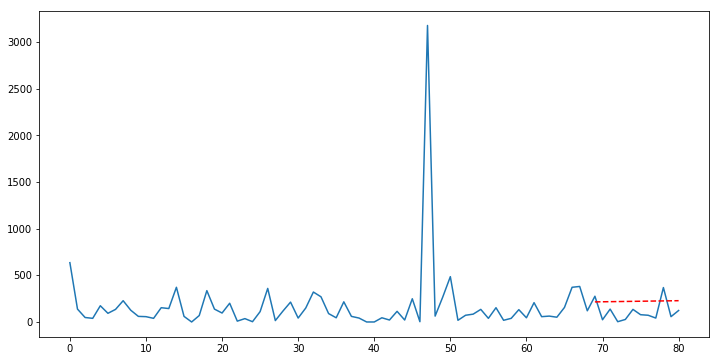

In [36]:
data["Actual 5"].plot(figsize=(12,6))
pred1.plot(style='r--');

# MAPE, GMRAE, UMBRAE

In [37]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [38]:
round(mean_absolute_percentage_error(trn1, pred1), 2)

842.71

In [39]:
def gmrae(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true1 = np.array(data["Actual 5"][68:80])
    return (np.prod(np.abs((y_true - y_pred)/(y_true - y_true1))))**(1/len(y_true))

In [40]:
round(gmrae(trn1, pred1), 2)

1.62

In [41]:
len(trn1)

12

In [42]:
np.array(trn1)

array([276,  24, 138,   3,  27, 135,  78,  72,  42, 369,  57, 123])

In [43]:
data["Actual 5"][68:80]

68    120
69    276
70     24
71    138
72      3
73     27
74    135
75     78
76     72
77     42
78    369
79     57
Name: Actual 5, dtype: int64

In [44]:
pred1

69    215.404221
70    216.580557
71    217.752355
72    218.924153
73    220.095951
74    221.267749
75    222.439546
76    223.611344
77    224.783142
78    225.954940
79    227.126738
80    228.298536
dtype: float64

In [94]:
def umbrae(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true1 = np.array(data["Actual 5"][68:80])
    mbrae=(np.sum(np.abs(y_true - y_pred)/(np.abs(y_true - y_pred)+np.abs(y_true - y_true1))))/len(y_true)
    return mbrae/(1-mbrae)

In [95]:
round(umbrae(trn1, pred1), 2)

1.35

### DOUBLE Exponentional smoothing Product #1

In [47]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # прогнозируем
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

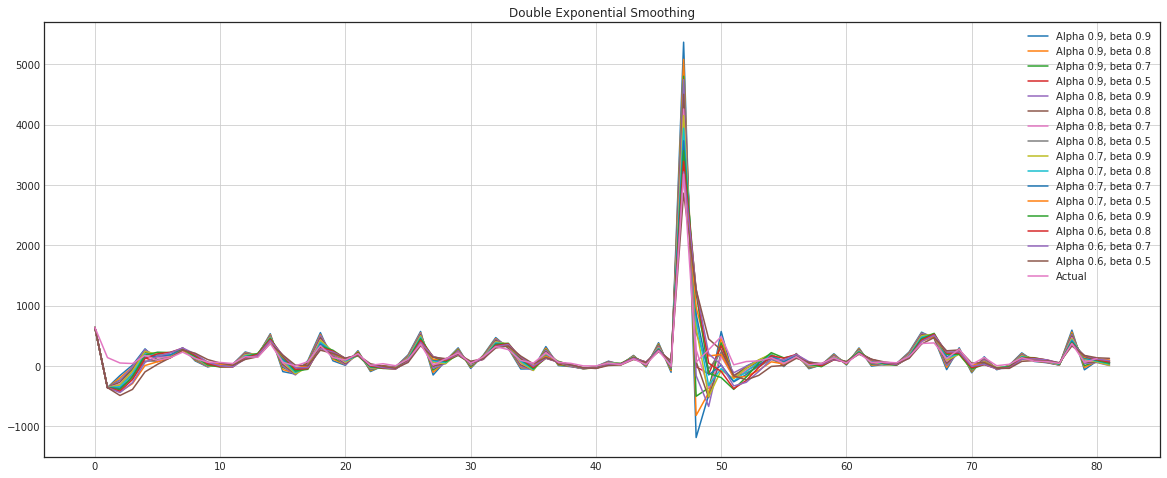

In [49]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.9, 0.8,0.7,0.6]:
        for beta in [0.9, 0.8,0.7,0.5]:
            plt.plot(double_exponential_smoothing(data["Actual 5"], alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(data["Actual 5"].values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

Now we have to tune two parameters — α and β. The former is responsible for the series smoothing around trend, and the latter for the smoothing of the trend itself. The bigger the values, the more weight the latest observations will have and the less smoothed the model series will be. Combinations of the parameters may produce really weird results, especially if set manually. We’ll look into choosing parameters automatically in a bit, immediately after triple exponential smoothing.

In [50]:
double_exponential_smoothing(data["Actual 5"],0.9,0.1)[69:81]

[270.243027543831,
 33.94268031676252,
 122.27780436554704,
 -1.1236856224737366,
 10.667297084746826,
 120.23633861784167,
 76.0919722955454,
 65.90925815671667,
 35.739153508729316,
 357.01561922814494,
 81.34186006955345,
 116.9237167474345]

In [51]:
data["Actual 5"][69:81]

69    276
70     24
71    138
72      3
73     27
74    135
75     78
76     72
77     42
78    369
79     57
80    123
Name: Actual 5, dtype: int64

In [52]:
for alpha in [0.9, 0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]:
        for beta in [0.9, 0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]:
            mape=mean_absolute_percentage_error(data["Actual 5"][69:81], double_exponential_smoothing(data["Actual 5"],alpha,beta)[69:81])
            print(alpha,"  ",beta,"  ", round(mape,3))

0.9    0.9    279.038
0.9    0.8    249.503
0.9    0.7    227.974
0.9    0.6    208.664
0.9    0.5    186.714
0.9    0.4    159.049
0.9    0.3    120.803
0.9    0.2    71.116
0.9    0.1    28.375
0.8    0.9    186.444
0.8    0.8    179.986
0.8    0.7    179.537
0.8    0.6    175.697
0.8    0.5    162.557
0.8    0.4    136.12
0.8    0.3    93.622
0.8    0.2    52.466
0.8    0.1    52.311
0.7    0.9    160.199
0.7    0.8    172.936
0.7    0.7    180.086
0.7    0.6    177.234
0.7    0.5    158.433
0.7    0.4    127.071
0.7    0.3    88.162
0.7    0.2    57.957
0.7    0.1    98.345
0.6    0.9    195.191
0.6    0.8    209.503
0.6    0.7    213.314
0.6    0.6    197.223
0.6    0.5    175.032
0.6    0.4    133.74
0.6    0.3    75.802
0.6    0.2    115.294
0.6    0.1    150.617
0.5    0.9    282.991
0.5    0.8    277.942
0.5    0.7    265.235
0.5    0.6    232.079
0.5    0.5    181.143
0.5    0.4    116.459
0.5    0.3    133.474
0.5    0.2    192.362
0.5    0.1    213.966
0.4    0.9    379.71


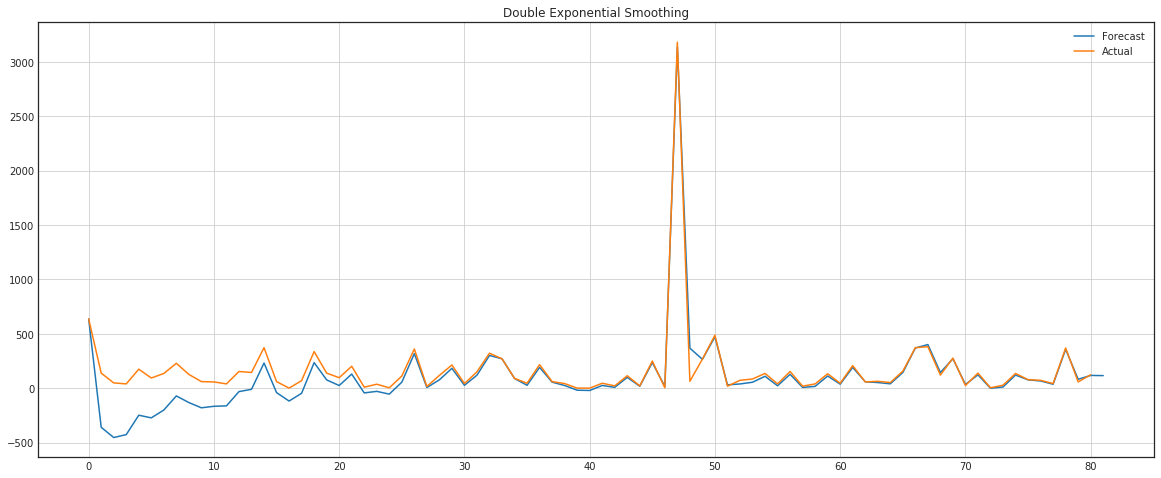

In [53]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    plt.plot(double_exponential_smoothing(data["Actual 5"], 0.9, 0.1), label = "Forecast");
    plt.plot(data["Actual 5"].values, label = "Actual");
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

In [54]:
round(mean_absolute_percentage_error(data["Actual 5"][69:81], 
                                     double_exponential_smoothing(data["Actual 5"],0.9,0.1)[69:81]),2)

28.37

In [55]:
round(gmrae(data["Actual 5"][69:81], 
                                     double_exponential_smoothing(data["Actual 5"],0.9,0.1)[69:81]),2)

0.1

In [56]:
round(umbrae(data["Actual 5"][69:81], 
                                     double_exponential_smoothing(data["Actual 5"],0.9,0.1)[69:81]),2)

0.14

## LINEAR REGRESSION

In [57]:
# Creating a copy of the initial datagrame to make various transformations 
xg = pd.DataFrame(data["Actual 5"].copy())
xg.columns = ["y"]

# Adding the lag of the target variable from 6 steps back up to 24
for i in range(1, 13):
    xg["lag_{}".format(i)] = xg.y.shift(i)

In [58]:
xg.head(13)

,y,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
0,636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,138,636.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,48,138.0,636.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,39,48.0,138.0,636.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,174,39.0,48.0,138.0,636.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,93,174.0,39.0,48.0,138.0,636.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,135,93.0,174.0,39.0,48.0,138.0,636.0,NaN,NaN,NaN,NaN,NaN,NaN
7,228,135.0,93.0,174.0,39.0,48.0,138.0,636.0,NaN,NaN,NaN,NaN,NaN
8,126,228.0,135.0,93.0,174.0,39.0,48.0,138.0,636.0,NaN,NaN,NaN,NaN
9,60,126.0,228.0,135.0,93.0,174.0,39.0,48.0,138.0,636.0,NaN,NaN,NaN


In [59]:
xg=xg.dropna()

In [60]:
y = xg["y"]
X = xg.drop(["y"], axis=1)

In [61]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [62]:
def plotModelResults(model, X_train, X_test, plot_intervals=False, plot_anomalies=False, scale=1.96):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_squared_error")
        #mae = cv.mean() * (-1)
        deviation = np.sqrt(cv.std())
        
        lower = prediction - (scale * deviation)
        upper = prediction + (scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');
    

In [63]:
# reserve 15% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.17)

In [64]:
# machine learning in two lines
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

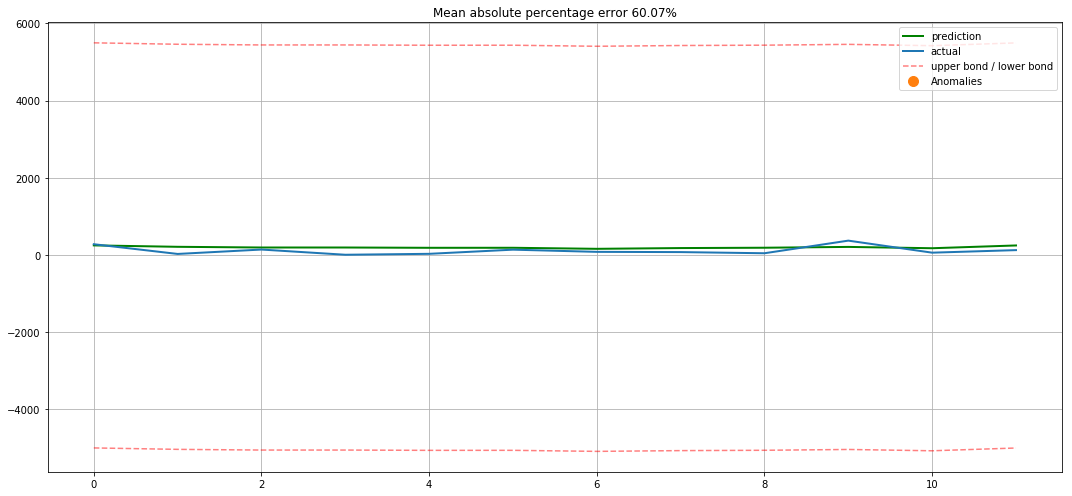

In [65]:
plotModelResults(lr, 
                 X_train=X_train, 
                 X_test=X_test, 
                 plot_intervals=True, plot_anomalies=True)

In [66]:
prediction = lr.predict(X_test)
print (prediction)

[246.00084152 208.95444803 190.9884867  190.85629029 183.22036983
 183.79299859 156.785409   176.46945614 185.0201786  206.27080097
 172.10845088 243.93987761]


In [67]:
print (y_test)

69    276
70     24
71    138
72      3
73     27
74    135
75     78
76     72
77     42
78    369
79     57
80    123
Name: y, dtype: int64


In [68]:
round(mean_absolute_percentage_error(y_test, prediction),2)

718.96

In [69]:
round(gmrae(y_test, prediction), 2)

1.22

In [70]:
round(umbrae(y_test, prediction), 2)

0.52

## XGBOOST 

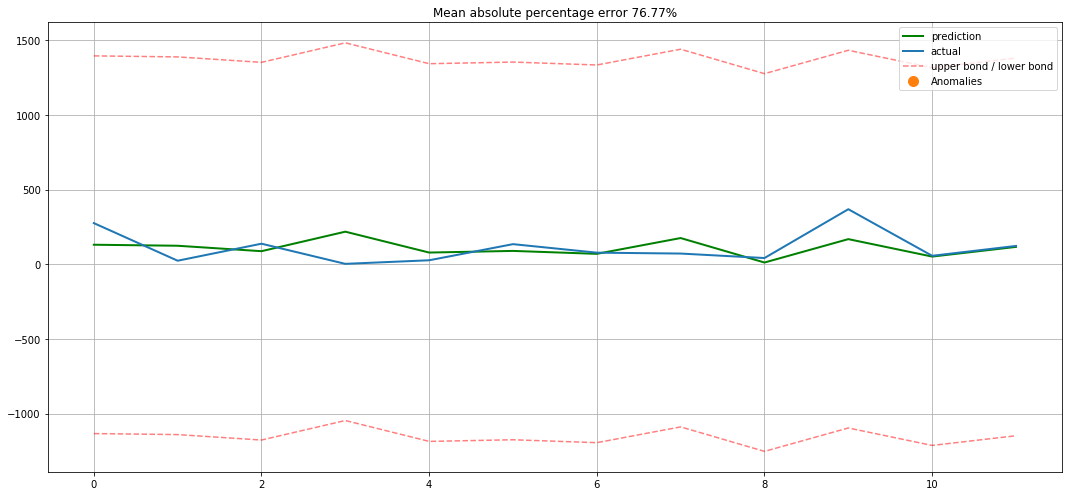

In [71]:
from xgboost import XGBRegressor 

xgb = XGBRegressor()
xgb.fit(X_train, y_train)

plotModelResults(xgb, 
                 X_train=X_train, 
                 X_test=X_test, 
                 plot_intervals=True, plot_anomalies=True)

In [72]:
prediction1 = xgb.predict(X_test)
print (prediction1)

[131.1314   124.2829    87.80806  218.56636   78.685425  89.67861
  70.10977  175.90329   11.892827 168.62863   51.71865  116.549995]


In [73]:
round(mean_absolute_percentage_error(y_test, prediction1),2)

684.35

In [74]:
round(gmrae(y_test, prediction1), 2)

0.54

In [75]:
round(umbrae(y_test, prediction1), 2)

0.39

# Facebook Prophet

In [76]:
from fbprophet import Prophet

In [77]:
ph1=pd.read_csv("For USML_date2.csv", sep=";")
ph1.tail(12)

,Date,Actual 1,Actual 2,Actual 3,Actual 4,Actual 5,Actual 6
69,31.07.2017,7272,1584,3933,3270,276,489
70,31.08.2017,8853,1125,4938,570,24,69
71,30.09.2017,11688,894,3381,1152,138,42
72,31.10.2017,5355,1266,2391,591,3,141
73,30.11.2017,5430,636,1179,459,27,168
74,31.12.2017,7959,678,2130,1104,135,0
75,31.01.2018,7158,654,1668,1182,78,51
76,28.02.2018,8493,183,3501,1464,72,87
77,31.03.2018,7713,945,4980,1425,42,18
78,30.04.2018,8676,3966,4011,2451,369,147


In [78]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

%matplotlib inline

In [79]:
import pandas as pd
ph1 = pd.DataFrame({'ds':ph1['Date'], 'y':ph1["Actual 5"]})

In [80]:
prediction_size = 12
train_df = ph1[:-prediction_size]
train_df.tail(n=3)

,ds,y
66,30.04.2017,372
67,31.05.2017,381
68,30.06.2017,120


In [81]:
m = Prophet()
m.fit(train_df)
predictions=12
future = m.make_future_dataframe(periods=predictions, freq='M')
forecast = m.predict(future)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [82]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
76,2018-02-28,556.105511,-51.180689,639.728554,556.105002,556.106117,-271.019488,-271.019488,-271.019488,-271.019488,-271.019488,-271.019488,0.0,0.0,0.0,285.086023
77,2018-03-31,561.525220,-220.466038,489.893104,561.524604,561.525930,-432.870940,-432.870940,-432.870940,-432.870940,-432.870940,-432.870940,0.0,0.0,0.0,128.654281
78,2018-04-30,566.770100,71.211229,748.236414,566.769375,566.770921,-152.770530,-152.770530,-152.770530,-152.770530,-152.770530,-152.770530,0.0,0.0,0.0,413.999570
79,2018-05-31,572.189809,162.524761,801.961122,572.188962,572.190764,-71.158677,-71.158677,-71.158677,-71.158677,-71.158677,-71.158677,0.0,0.0,0.0,501.031132
80,2018-06-30,577.434689,-232.717247,418.277298,577.433704,577.435788,-481.154168,-481.154168,-481.154168,-481.154168,-481.154168,-481.154168,0.0,0.0,0.0,96.280521


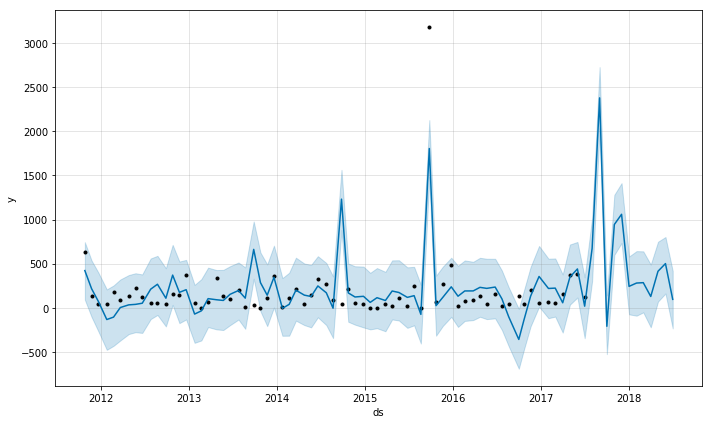

In [83]:
m.plot(forecast);

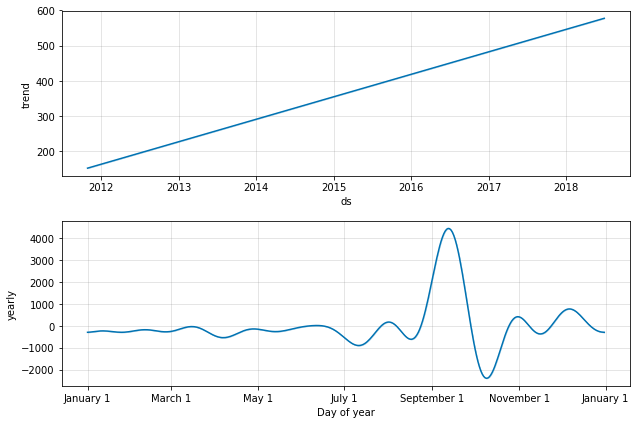

In [84]:
m.plot_components(forecast);

In [85]:
def make_comparison_dataframe(historical, forecast):
    """Join the history with the forecast.
    
       The resulting dataset will contain columns 'yhat', 'yhat_lower', 'yhat_upper' and 'y'.
    """
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index("ds"))

In [86]:
cmp_df = make_comparison_dataframe(ph1, forecast)
cmp_df.tail()

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2018-02-28,285.086023,-51.180689,639.728554,72
2018-03-31,128.654281,-220.466038,489.893104,42
2018-04-30,413.999570,71.211229,748.236414,369
2018-05-31,501.031132,162.524761,801.961122,57
2018-06-30,96.280521,-232.717247,418.277298,123


In [87]:
def calculate_forecast_errors(df, prediction_size):
    """Calculate MAPE and MAE of the forecast.
    
       Args:
           df: joined dataset with 'y' and 'yhat' columns.
           prediction_size: number of days at the end to predict.
    """
    
    # Make a copy
    df = df.copy()
    
    # Now we calculate the values of e_i and p_i according to the formulas given in the article above.
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    # Recall that we held out the values of the last `prediction_size` days
    # in order to predict them and measure the quality of the model. 
    
    # Now cut out the part of the data which we made our prediction for.
    predicted_part = df[-prediction_size:]
    
    # Define the function that averages absolute error values over the predicted part.
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    # Now we can calculate MAPE and MAE and return the resulting dictionary of errors.
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}

In [88]:
for err_name, err_value in calculate_forecast_errors(cmp_df, predictions).items():
    print(err_name, err_value)

MAPE 3919.3561565105842
MAE 516.5014557114122


In [89]:
cmp_df['y'][-12:]

ds
2017-07-31    276
2017-08-31     24
2017-09-30    138
2017-10-31      3
2017-11-30     27
2017-12-31    135
2018-01-31     78
2018-02-28     72
2018-03-31     42
2018-04-30    369
2018-05-31     57
2018-06-30    123
Name: y, dtype: int64

In [90]:
cmp_df['yhat'][-12:]

ds
2017-07-31     674.752497
2017-08-31    2377.467187
2017-09-30    -208.836096
2017-10-31     943.569512
2017-11-30    1059.204096
2017-12-31     243.003729
2018-01-31     280.693867
2018-02-28     285.086023
2018-03-31     128.654281
2018-04-30     413.999570
2018-05-31     501.031132
2018-06-30      96.280521
Name: yhat, dtype: float64

In [91]:
round(mean_absolute_percentage_error(cmp_df['y'][-12:], cmp_df['yhat'][-12:]),2)

3919.36

In [92]:
round(gmrae(cmp_df['y'][-12:], cmp_df['yhat'][-12:]), 2)

3.04

In [93]:
round(umbrae(cmp_df['y'][-12:], cmp_df['yhat'][-12:]), 2)

0.68